In [1]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_advanced"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_advanced


In [3]:
import lightning as L
import torch
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.callbacks import RichProgressBar, RichModelSummary
from lightning.pytorch.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    DeviceStatsMonitor,
    LearningRateMonitor,
    ThroughputMonitor,
)
from lightning.pytorch.loggers import CSVLogger

In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_epochs=25

cuda


In [5]:
from engine import PyTorchMLP, LightningMLP, LightningData
from utils import plot_csv_logs

In [6]:
dm = LightningData(num_workers=0, batch_size=64)

In [7]:
dm.setup("fit")
dm.setup("test")

In [8]:
print("Training set size:", len(dm.train_dataset))
print("Validation set size:", len(dm.val_dataset))
print("Test set size:", len(dm.test_dataset))

Training set size: 14400
Validation set size: 1600
Test set size: 1600


In [9]:
num_steps = num_epochs * len(dm.train_dataloader())
print(num_steps)

5625


In [10]:
from collections import Counter

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

train_counter = Counter()
for features, labels in train_loader:
    train_counter.update(labels.tolist())

print("\nTraining label distribution:")
print(sorted(train_counter.items()))


val_counter = Counter()
for features, labels in val_loader:
    val_counter.update(labels.tolist())

print("\nValidation label distribution:")
print(sorted(val_counter.items()))


test_counter = Counter()
for features, labels in test_loader:
    test_counter.update(labels.tolist())

print("\nTest label distribution:")
print(sorted(test_counter.items()))


Training label distribution:
[(0, 7209), (1, 7191)]

Validation label distribution:
[(0, 791), (1, 809)]

Test label distribution:
[(0, 791), (1, 809)]


**Model Checkpointing**

In [11]:
torch.manual_seed(123)
pytorch_model = PyTorchMLP(num_features=100, num_classes=2).to(device)

In [12]:
callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True),
    RichProgressBar(),
    RichModelSummary(max_depth=-1),
]

In [13]:
lightning_model = LightningMLP(model=pytorch_model, learning_rate=0.05,lr_scheduling=None, num_iters=num_steps)

trainer = L.Trainer(
    callbacks=callbacks,  # New!!!
    max_epochs=num_epochs,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="csv_logs/", name="my-model"),
    deterministic=True,
    enable_progress_bar=True,
    enable_model_summary=True,
)

trainer.fit(model=lightning_model, datamodule=dm)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name               ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ model              │ PyTorchMLP         │ 15.6 K │ train │
│ 1  │ model.all_layers   │ Sequential         │ 15.6 K │ train │
│ 2  │ model.all_layers.0 │ Linear             │ 10.1 K │ train │
│ 3  │ model.all_layers.1 │ BatchNorm1d        │    200 │ train │
│ 4  │ model.all_layers.2 │ Dropout1d          │      0 │ train │
│ 5  │ model.all_layers.3 │ ReLU               │      0 │ train │
│ 6  │ model.all_layers.4 │ Linear             │  5.0 K │ train │
│ 7  │ model.all_layers.5 │ BatchNorm1d        │    100 │ train │
│ 8  │ model.all_layers.6 │ ReLU               │      0 │ train │
│ 9  │ model.all_layers.7 │ Dropout1d          │      0 │ train │
│ 10 │ model.all_layers.8 │ Linear             │    102 │ train │
│ 11 │ criterion          │ CrossEntropyLoss   │      0 │ train │
│ 12 │ train_acc          │ MulticlassAccuracy │      0 │ train │
│ 13 │ test_acc           │ MulticlassAccuracy │      0 │ train │
└────┴────────────────────┴────────────────────┴────────┴───────┘

Trainable params: 15.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 15.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=25` reached.


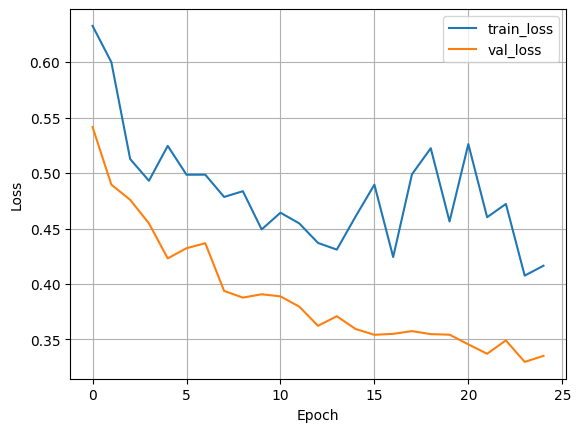

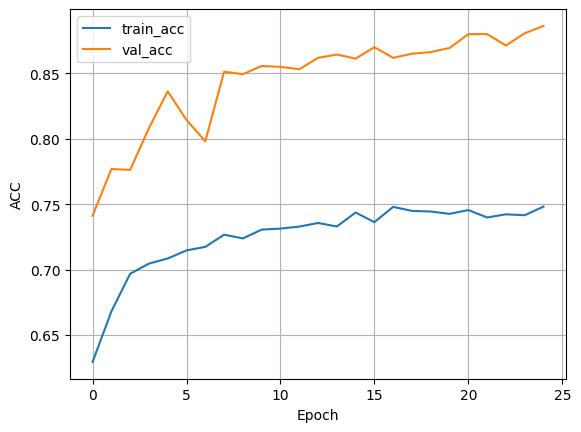

In [14]:
plot_csv_logs(trainer)

##### Evaluations using checkpoints just after training and restore a model from best

In [15]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")

Restoring states from the checkpoint path at csv_logs/my-model/version_10/checkpoints/epoch=24-step=5625.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at csv_logs/my-model/version_10/checkpoints/epoch=24-step=5625.ckpt


Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8862500190734863     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8862500190734863}]

In [16]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="last")

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_advanced/csv_logs/my-model/version_10/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_advanced/csv_logs/my-model/version_10/checkpoints/last.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8862500190734863     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8862500190734863}]

In [17]:
path = trainer.checkpoint_callback.best_model_path

lightning_model = LightningMLP.load_from_checkpoint(
    path, learning_rate=0.1, model=pytorch_model
)
lightning_model.eval()

trainer.test(model=lightning_model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8862500190734863     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8862500190734863}]

**LR SCHEDULING**

In [18]:
from lightning.pytorch.tuner import Tuner

Finding right LR

In [19]:
torch.manual_seed(181)
dm = LightningData(num_workers=0, batch_size=64)
pytorch_model = PyTorchMLP(num_features=100, num_classes=2).to(device)
lightning_model = LightningMLP(model=pytorch_model, learning_rate=0.05,lr_scheduling=None, num_iters=num_steps)

In [20]:
callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True),
    RichProgressBar(),
    RichModelSummary(max_depth=-1),
]

trainer = L.Trainer(
    callbacks=callbacks,  # New!!!
    max_epochs=num_epochs,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="csv_logs/", name="my-model"),
    deterministic=True,
    enable_progress_bar=True,
    enable_model_summary=True,
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [21]:
# create a tuner
tuner = Tuner(trainer)
# sets hparams.lr or hparams.learning_rate to that learning rate
lr_finder = tuner.lr_find(lightning_model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_advanced/.lr_find_b54eb693-7435-44d4-9cc4-b3500f0cdace.ckpt
Restored all states from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_advanced/.lr_find_b54eb693-7435-44d4-9cc4-b3500f0cdace.ckpt


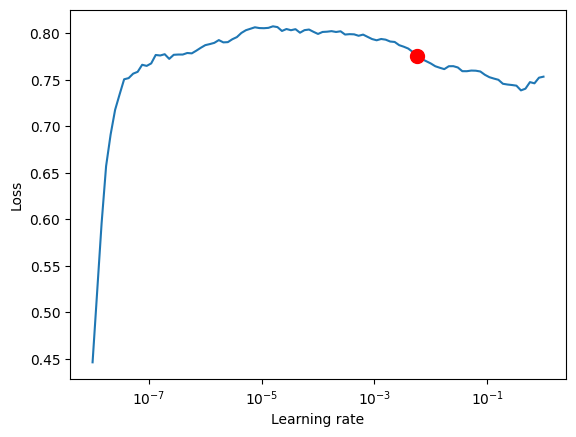

In [22]:
fig = lr_finder.plot(suggest=True)

In [23]:
# get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

0.005754399373371567


In [53]:
# setting new lr
lightning_model.learning_rate = new_lr

In [54]:
# training with new lr
trainer.fit(model=lightning_model, datamodule=dm)

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory csv_logs/my-model/version_15/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name               ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ model              │ PyTorchMLP         │ 15.6 K │ train │
│ 1  │ model.all_layers   │ Sequential         │ 15.6 K │ train │
│ 2  │ model.all_layers.0 │ Linear             │ 10.1 K │ train │
│ 3  │ model.all_layers.1 │ BatchNorm1d        │    200 │ train │
│ 4  │ model.all_layers.2 │ Dropout1d          │      0 │ train │
│ 5  │ model.all_layers.3 │ ReLU               │      0 │ train │
│ 6  │ model.all_layers.4 │ Linear             │  5.0 K │ train │
│ 7  │ model.all_layers.5 │ BatchNorm1d        │    100 │ train │
│ 8  │ model.all_layers.6 │ ReLU               │      0 │ train │
│ 9  │ model.all_layers.7 │ Dropout1d          │      0 │ train │
│ 10 │ model.all_layers.8 │ Linear             │    102 │ train │
│ 11 │ criterion          │ CrossEntropyLoss   │      0 │ train │
│ 12 │ train_acc          │ MulticlassAccuracy │      0 │ train │
│ 13 │ test_acc           │ MulticlassAccuracy │      0 │ train │
└────┴────────────────────┴────────────────────┴────────┴───────┘

Trainable params: 15.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 15.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=25` reached.


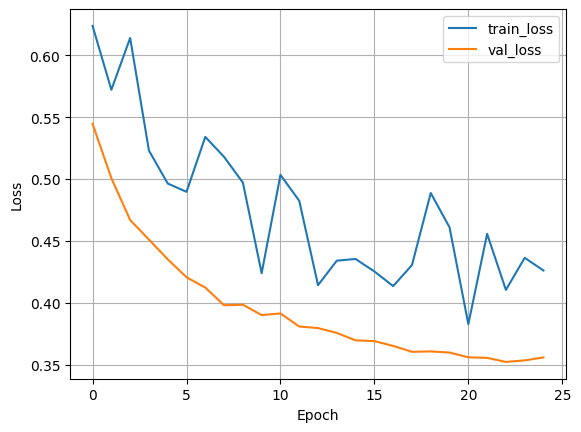

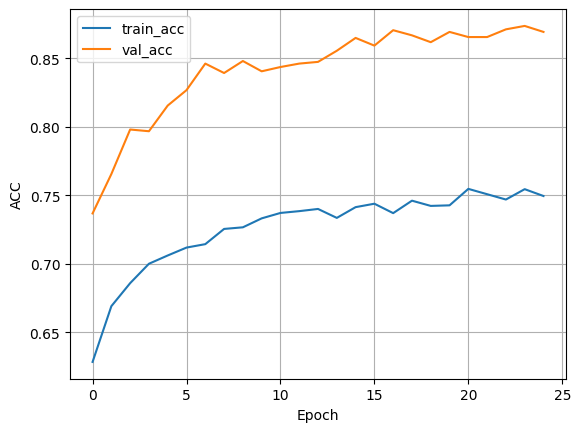

In [55]:
plot_csv_logs(trainer)

In [56]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")

Restoring states from the checkpoint path at csv_logs/my-model/version_15/checkpoints/epoch=23-step=5400.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at csv_logs/my-model/version_15/checkpoints/epoch=23-step=5400.ckpt


Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8737499713897705     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8737499713897705}]

In [57]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="last")

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_advanced/csv_logs/my-model/version_15/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_advanced/csv_logs/my-model/version_15/checkpoints/last.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8693749904632568     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8693749904632568}]

**Additional Callbacks**

In [58]:
torch.manual_seed(181)
dm = LightningData(num_workers=0, batch_size=64)
pytorch_model = PyTorchMLP(num_features=100, num_classes=2).to(device)
lightning_model = LightningMLP(model=pytorch_model, learning_rate=new_lr,lr_scheduling=None, num_iters=num_steps)

In [59]:
callbacks = [
    ModelCheckpoint(
        save_top_k=1, mode="max", monitor="val_acc", save_last=True, verbose=True
    ),
    RichProgressBar(),
    RichModelSummary(max_depth=-1, verbose=True),
    EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True),
    DeviceStatsMonitor(),
]

trainer = L.Trainer(
    callbacks=callbacks,  # New!!!
    max_epochs=num_epochs,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="csv_logs/", name="my-model"),
    deterministic=True,
    enable_progress_bar=True,
    enable_model_summary=True,
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=lightning_model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name               ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ model              │ PyTorchMLP         │ 15.6 K │ train │
│ 1  │ model.all_layers   │ Sequential         │ 15.6 K │ train │
│ 2  │ model.all_layers.0 │ Linear             │ 10.1 K │ train │
│ 3  │ model.all_layers.1 │ BatchNorm1d        │    200 │ train │
│ 4  │ model.all_layers.2 │ Dropout1d          │      0 │ train │
│ 5  │ model.all_layers.3 │ ReLU               │      0 │ train │
│ 6  │ model.all_layers.4 │ Linear             │  5.0 K │ train │
│ 7  │ model.all_layers.5 │ BatchNorm1d        │    100 │ train │
│ 8  │ model.all_layers.6 │ ReLU               │      0 │ train │
│ 9  │ model.all_layers.7 │ Dropout1d          │      0 │ train │
│ 10 │ model.all_layers.8 │ Linear             │    102 │ train │
│ 11 │ criterion          │ CrossEntropyLoss   │      0 │ train │
│ 12 │ train_acc          │ MulticlassAccuracy │      0 │ train │
│ 13 │ test_acc           │ MulticlassAccuracy │      0 │ train │
└────┴────────────────────┴────────────────────┴────────┴───────┘

Trainable params: 15.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 15.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

Metric val_loss improved. New best score: 0.545
Epoch 0, global step 225: 'val_acc' reached 0.73625 (best 0.73625), saving model to 'csv_logs/my-model/version_16/checkpoints/epoch=0-step=225.ckpt' as top 1
Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.500
Epoch 1, global step 450: 'val_acc' reached 0.77438 (best 0.77438), saving model to 'csv_logs/my-model/version_16/checkpoints/epoch=1-step=450.ckpt' as top 1
Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.465
Epoch 2, global step 675: 'val_acc' reached 0.79375 (best 0.79375), saving model to 'csv_logs/my-model/version_16/checkpoints/epoch=2-step=675.ckpt' as top 1
Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.454
Epoch 3, global step 900: 'val_acc' reached 0.79438 (best 0.79438), saving model to 'csv_logs/my-model/version_16/checkpoints/epoch=3-step=900.ckpt' as top 1
Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.437
Epoch 4, global 

In [ ]:
path = trainer.checkpoint_callback.best_model_path
print(path)

In [ ]:
plot_csv_logs(trainer)

In [ ]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")

**LR Scheduler**

In [ ]:
# step scheduling

In [ ]:
torch.manual_seed(181)
dm = LightningData(num_workers=0, batch_size=64)
pytorch_model = PyTorchMLP(num_features=100, num_classes=2).to(device)
lightning_model = LightningMLP(model=pytorch_model, learning_rate=new_lr,lr_scheduling='step', num_iters=num_steps)

In [ ]:
callbacks = [
    ModelCheckpoint(
        save_top_k=1, mode="max", monitor="val_acc", save_last=True, verbose=True
    ),
    RichProgressBar(),
    RichModelSummary(max_depth=-1, verbose=True),
    EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True),
    DeviceStatsMonitor(),
]

In [67]:
trainer = L.Trainer(
    callbacks=callbacks,  # New!!!
    max_epochs=num_epochs,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="csv_logs/", name="my-model"),
    deterministic=True,
    enable_progress_bar=True,
    enable_model_summary=True,
)

trainer.fit(model=lightning_model, datamodule=dm)

Epoch 24/24 ━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 119/225 0:00:01 • 0:00:02 70.25it/s v_num: 17.000 train_loss: 0.515   
                                                                                 val_loss: 0.348 val_acc: 0.874    
                                                                                 train_acc: 0.742                  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



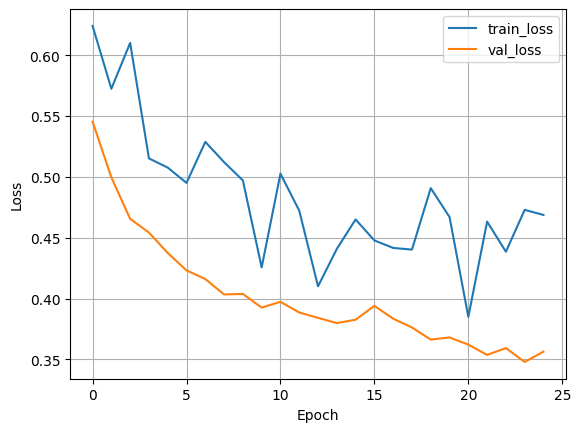

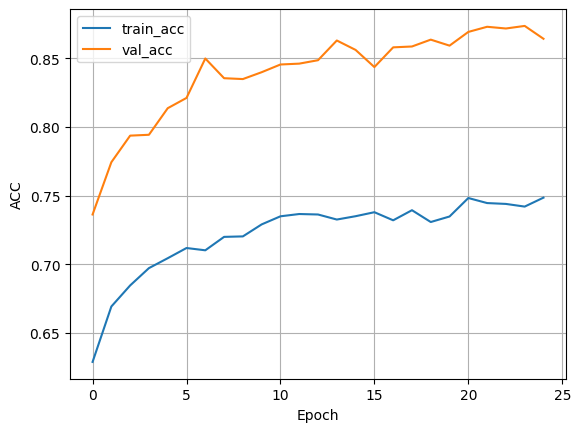

In [68]:
plot_csv_logs(trainer)

In [69]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")

Restoring states from the checkpoint path at csv_logs/my-model/version_17/checkpoints/epoch=23-step=5400.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at csv_logs/my-model/version_17/checkpoints/epoch=23-step=5400.ckpt


Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8737499713897705     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8737499713897705}]

In [70]:
# plateau

In [71]:
torch.manual_seed(181)
dm = LightningData(num_workers=0, batch_size=64)
pytorch_model = PyTorchMLP(num_features=100, num_classes=2).to(device)
lightning_model = LightningMLP(model=pytorch_model, learning_rate=new_lr,lr_scheduling='plateau', num_iters=num_steps)

In [72]:
callbacks = [
    ModelCheckpoint(
        save_top_k=1, mode="max", monitor="val_acc", save_last=True, verbose=True
    ),
    RichProgressBar(),
    RichModelSummary(max_depth=-1, verbose=True),
    EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True),
    DeviceStatsMonitor(),
]

In [73]:
trainer = L.Trainer(
    callbacks=callbacks,  # New!!!
    max_epochs=num_epochs,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="csv_logs/", name="my-model"),
    deterministic=True,
    enable_progress_bar=True,
    enable_model_summary=True,
)

trainer.fit(model=lightning_model, datamodule=dm)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name               ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ model              │ PyTorchMLP         │ 15.6 K │ train │
│ 1  │ model.all_layers   │ Sequential         │ 15.6 K │ train │
│ 2  │ model.all_layers.0 │ Linear             │ 10.1 K │ train │
│ 3  │ model.all_layers.1 │ BatchNorm1d        │    200 │ train │
│ 4  │ model.all_layers.2 │ Dropout1d          │      0 │ train │
│ 5  │ model.all_layers.3 │ ReLU               │      0 │ train │
│ 6  │ model.all_layers.4 │ Linear             │  5.0 K │ train │
│ 7  │ model.all_layers.5 │ BatchNorm1d        │    100 │ train │
│ 8  │ model.all_layers.6 │ ReLU               │      0 │ train │
│ 9  │ model.all_layers.7 │ Dropout1d          │      0 │ train │
│ 10 │ model.all_layers.8 │ Linear             │    102 │ train │
│ 11 │ criterion          │ CrossEntropyLoss   │      0 │ train │
│ 12 │ train_acc          │ MulticlassAccuracy │      0 │ train │
│ 13 │ test_acc           │ MulticlassAccuracy │      0 │ train │
└────┴────────────────────┴────────────────────┴────────┴───────┘

Trainable params: 15.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 15.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

Metric val_loss improved. New best score: 0.545
Epoch 0, global step 225: 'val_acc' reached 0.73625 (best 0.73625), saving model to 'csv_logs/my-model/version_18/checkpoints/epoch=0-step=225.ckpt' as top 1
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.416
Epoch 6, global step 1575: 'val_acc' reached 0.85000 (best 0.85000), saving model to 'csv_logs/my-model/version_18/checkpoints/epoch=6-step=1575.ckpt' as top 1
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.386
Epoch 12, global step 2925: 'val_acc' was not in top 1
Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.363
Epoch 18, global step 4275: 'val_

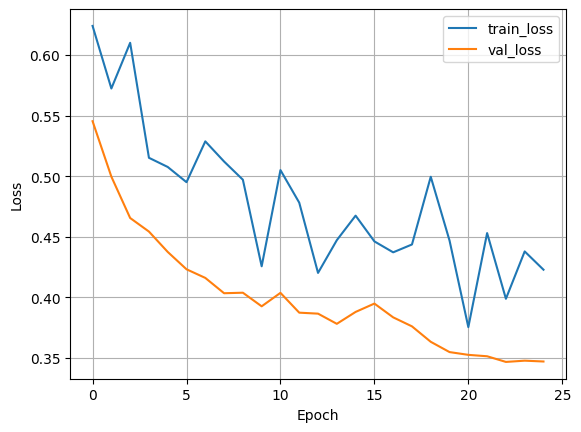

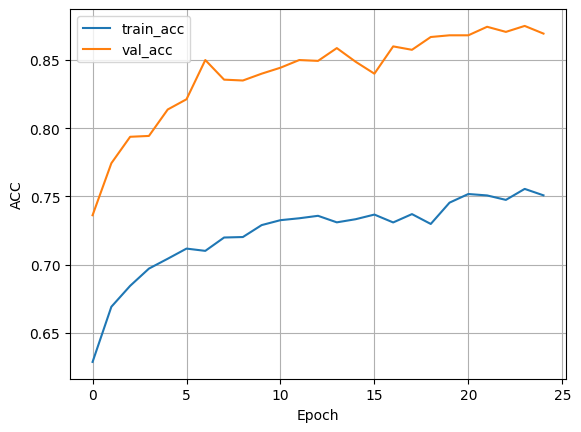

In [74]:
plot_csv_logs(trainer)

In [75]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")

Restoring states from the checkpoint path at csv_logs/my-model/version_18/checkpoints/epoch=23-step=5400.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at csv_logs/my-model/version_18/checkpoints/epoch=23-step=5400.ckpt


Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.875           │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.875}]

In [76]:
# cosine anealing

In [77]:
torch.manual_seed(181)
dm = LightningData(num_workers=0, batch_size=64)
pytorch_model = PyTorchMLP(num_features=100, num_classes=2).to(device)
lightning_model = LightningMLP(model=pytorch_model, learning_rate=new_lr,lr_scheduling='cosine', num_iters=num_steps)

In [78]:
callbacks = [
    ModelCheckpoint(
        save_top_k=1, mode="max", monitor="val_acc", save_last=True, verbose=True
    ),
    RichProgressBar(),
    RichModelSummary(max_depth=-1, verbose=True),
    EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True),
    DeviceStatsMonitor(),
]

In [79]:
trainer = L.Trainer(
    callbacks=callbacks,  # New!!!
    max_epochs=num_epochs,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="csv_logs/", name="my-model"),
    deterministic=True,
    enable_progress_bar=True,
    enable_model_summary=True,
)

trainer.fit(model=lightning_model, datamodule=dm)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name               ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ model              │ PyTorchMLP         │ 15.6 K │ train │
│ 1  │ model.all_layers   │ Sequential         │ 15.6 K │ train │
│ 2  │ model.all_layers.0 │ Linear             │ 10.1 K │ train │
│ 3  │ model.all_layers.1 │ BatchNorm1d        │    200 │ train │
│ 4  │ model.all_layers.2 │ Dropout1d          │      0 │ train │
│ 5  │ model.all_layers.3 │ ReLU               │      0 │ train │
│ 6  │ model.all_layers.4 │ Linear             │  5.0 K │ train │
│ 7  │ model.all_layers.5 │ BatchNorm1d        │    100 │ train │
│ 8  │ model.all_layers.6 │ ReLU               │      0 │ train │
│ 9  │ model.all_layers.7 │ Dropout1d          │      0 │ train │
│ 10 │ model.all_layers.8 │ Linear             │    102 │ train │
│ 11 │ criterion          │ CrossEntropyLoss   │      0 │ train │
│ 12 │ train_acc          │ MulticlassAccuracy │      0 │ train │
│ 13 │ test_acc           │ MulticlassAccuracy │      0 │ train │
└────┴────────────────────┴────────────────────┴────────┴───────┘

Trainable params: 15.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 15.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

Metric val_loss improved. New best score: 0.545
Epoch 0, global step 225: 'val_acc' reached 0.73687 (best 0.73687), saving model to 'csv_logs/my-model/version_19/checkpoints/epoch=0-step=225.ckpt' as top 1
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.421
Epoch 5, global step 1350: 'val_acc' reached 0.82687 (best 0.82687), saving model to 'csv_logs/my-model/version_19/checkpoints/epoch=5-step=1350.ckpt' as top 1
Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.412
Epoch 6, global step 1575: 'val_acc' reached 0.84625 (best 0.84625), saving model to 'csv_logs/my-model/version_19/checkpoints/epoch=6-step=1575.ckpt' as top 1
Metr

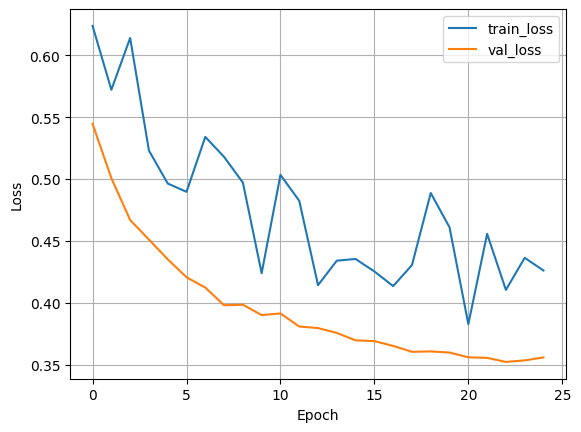

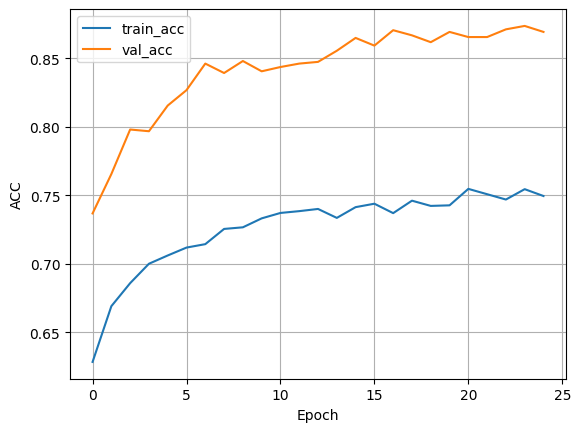

In [80]:
plot_csv_logs(trainer)

In [81]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")

Restoring states from the checkpoint path at csv_logs/my-model/version_19/checkpoints/epoch=23-step=5400.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at csv_logs/my-model/version_19/checkpoints/epoch=23-step=5400.ckpt


Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8737499713897705     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8737499713897705}]

**Basic testing**

In [102]:
from lightning.pytorch.utilities.model_summary import ModelSummary

In [103]:
torch.manual_seed(181)
dm = LightningData(num_workers=0, batch_size=64)
pytorch_model_c = PyTorchMLP(num_features=100, num_classes=2).to(device)
lightning_model_c = LightningMLP(model=pytorch_model_c, learning_rate=new_lr,lr_scheduling='step', num_iters=num_steps)

In [105]:
summary = ModelSummary(lightning_model_c, max_depth=-1)
print(summary)

   | Name               | Type               | Params | Mode 
-------------------------------------------------------------------
0  | model              | PyTorchMLP         | 15.6 K | train
1  | model.all_layers   | Sequential         | 15.6 K | train
2  | model.all_layers.0 | Linear             | 10.1 K | train
3  | model.all_layers.1 | BatchNorm1d        | 200    | train
4  | model.all_layers.2 | Dropout1d          | 0      | train
5  | model.all_layers.3 | ReLU               | 0      | train
6  | model.all_layers.4 | Linear             | 5.0 K  | train
7  | model.all_layers.5 | BatchNorm1d        | 100    | train
8  | model.all_layers.6 | ReLU               | 0      | train
9  | model.all_layers.7 | Dropout1d          | 0      | train
10 | model.all_layers.8 | Linear             | 102    | train
11 | criterion          | CrossEntropyLoss   | 0      | train
12 | train_acc          | MulticlassAccuracy | 0      | train
13 | test_acc           | MulticlassAccuracy | 0      | train
--

In [106]:
callbacks = [
    RichProgressBar(),
    RichModelSummary(max_depth=-1, verbose=True),
    DeviceStatsMonitor(),
]

In [109]:
trainer = L.Trainer(
    overfit_batches=1, # same 1 batch if trained mutiple times should be very acc
    callbacks=callbacks, 
    max_epochs=100,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="csv_logs/", name="my-model"),
    deterministic=True,
    enable_progress_bar=True,
    enable_model_summary=True,
)

trainer.fit(model=lightning_model_c, datamodule=dm)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name               ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ model              │ PyTorchMLP         │ 15.6 K │ train │
│ 1  │ model.all_layers   │ Sequential         │ 15.6 K │ train │
│ 2  │ model.all_layers.0 │ Linear             │ 10.1 K │ train │
│ 3  │ model.all_layers.1 │ BatchNorm1d        │    200 │ train │
│ 4  │ model.all_layers.2 │ Dropout1d          │      0 │ train │
│ 5  │ model.all_layers.3 │ ReLU               │      0 │ train │
│ 6  │ model.all_layers.4 │ Linear             │  5.0 K │ train │
│ 7  │ model.all_layers.5 │ BatchNorm1d        │    100 │ train │
│ 8  │ model.all_layers.6 │ ReLU               │      0 │ train │
│ 9  │ model.all_layers.7 │ Dropout1d          │      0 │ train │
│ 10 │ model.all_layers.8 │ Linear             │    102 │ train │
│ 11 │ criterion          │ CrossEntropyLoss   │      0 │ train │
│ 12 │ train_acc          │ MulticlassAccuracy │      0 │ train │
│ 13 │ test_acc           │ MulticlassAccuracy │      0 │ train │
└────┴────────────────────┴────────────────────┴────────┴───────┘

Trainable params: 15.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 15.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


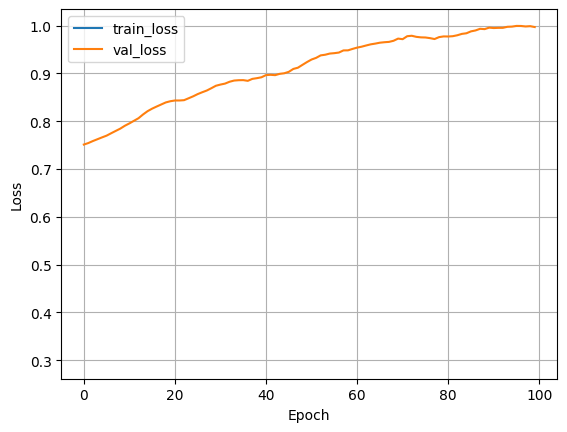

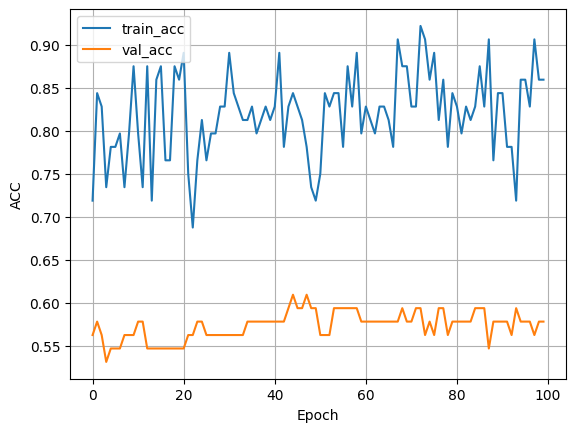

In [110]:
plot_csv_logs(trainer)

#####################---------------------------------------------############################